# Replicate: FastSAM 
### pytorch checkpoint (.pt)

In [ ]:
# New conda env
"""
# clean env wipe & activate
conda env remove --name FastSAM_chkpt -y
conda create -n FastSAM_chkpt python=3.10 -y
conda activate FastSAM_chkpt

# Instalation of FastSAM repo requirements
cd ~/FastSAM
pip install -r requirements.txt
python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3


# typical np version mismatch
pip uninstall -y numpy
pip install "numpy>=1.19.2,<2.0"

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

pip install onnx==1.13.1 onnxruntime==1.14.1 numpy==1.26.4 --default-timeout=1000

pip install git+https://github.com/openai/CLIP.git

"""



# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# clean env wipe & activate\nconda env remove --name FastSAM_chkpt -y\nconda create -n FastSAM_chkpt python=3.10 -y\nconda activate FastSAM_chkpt\n\n# Instalation of FastSAM repo requirements\ncd ~/FastSAM\npip install -r requirements.txt\npython setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install "numpy>=1.19.2,<2.0"\n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py install\ncd ~\n\npip install onnx==1.13.1 onnxruntime==1.14.1 numpy==1.26.4 --default-timeout=1000\n\npip install git+https://github.com/openai/CLIP.git\n\n'

In [17]:
# FastSAM Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
import argparse
from fastsam import FastSAM, FastSAMPrompt 
import ast
import torch
from PIL import Image

# Import patch
import sys
import os

import sys
sys.path.append('/home/copter/FastSAM')

# Now your import should work
from utils.tools import convert_box_xywh_to_xyxy

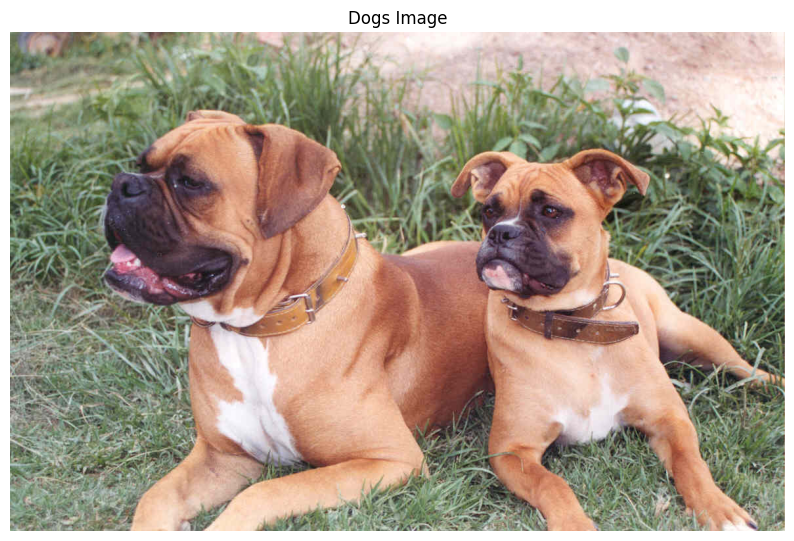

In [18]:

# Load the image
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
image = PIL.Image.open(image_path)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')  # Hide axes for cleaner display
plt.title("Dogs Image")
plt.show()

In [19]:
# python Inference.py --model_path ./weights/FastSAM.pt --img_path ./images/dogs.jpg

In [20]:
# default args
model_path = "/home/copter/weights/CASIA-IVA-Lab_FastSAM-s.pt"
img_path = image_path
imgsz = 1024
iou = 0.9
text_prompt = None
conf = 0.4
output = "/home/copter/jetson_benchmark/output"
randomcolor = True
point_prompt = "[[0,0]]"
point_label = "[0]"   # 0:background, 1:foreground"
box_prompt="[[0,0,0,0]]" # jhelp="[[x,y,w,h],[x2,y2,w2,h2]]
better_quality="False"

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("device: ", device)

retina=True # "draw high-resolution segmentation masks"
withContours=False  # "draw the edges of the masks"

device:  cuda


In [21]:
# Load model
model = FastSAM(model_path)
point_prompt = ast.literal_eval(point_prompt)
box_prompt = convert_box_xywh_to_xyxy(ast.literal_eval(box_prompt))
point_label = ast.literal_eval(point_label)

# Image input
input = Image.open(image_path)
input = input.convert("RGB")

/home/copter/miniconda3/envs/FastSAM_chkpt/lib/python3.10/site-packages/ultralytics/nn/tasks.py:518: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, ma

In [22]:
everything_results = model(
    input,
    device=device,
    retina_masks=retina,
    imgsz=imgsz,
    conf=conf,
    iou=iou    
    )
bboxes = None
points = None
point_label = None

prompt_process = FastSAMPrompt(input, everything_results, device=device)

# if given bbox prompts
if box_prompt[0][2] != 0 and box_prompt[0][3] != 0:
        ann = prompt_process.box_prompt(bboxes=box_prompt)
        bboxes = box_prompt
# if given text prompts
elif text_prompt != None:
    ann = prompt_process.text_prompt(text=text_prompt)
# if given a point prompt
elif point_prompt[0] != [0, 0]:
    ann = prompt_process.point_prompt(
        points=point_prompt, pointlabel=point_label
    )
    points = point_prompt
    point_label = point_label
# return all masks mode
else:
    ann = prompt_process.everything_prompt()
prompt_process.plot(
    annotations=ann,
    output_path=output + "/fastsam_demo.jpg",
    bboxes = bboxes,
    points = points,
    point_label = point_label,
    withContours=withContours,
    better_quality=better_quality,
)



0: 672x1024 15 objects, 95.7ms
Speed: 13.6ms preprocess, 95.7ms inference, 31.8ms postprocess per image at shape (1, 3, 1024, 1024)
